In [1]:
# Author: Alireza P. Nouri
# email: apashamoham@miners.utep.edu
# date: 12/14/2023
# this is a code includes all evaluation metrics to assess the quality of the storytelling algorithm

In [2]:
#import packages
from transformers import BertTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.manifold import TSNE

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from dataset_reader import dataset_loader
from contextual_embedding.contextual_embedding import bert_embedding

import seaborn as sns
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
import copy
import random 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import layers, Model
import nltk

from copy import copy, deepcopy

2023-12-16 19:41:31.344937: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 19:41:31.344968: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 19:41:31.345002: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-16 19:41:31.351381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# device = torch.device('cuda:1')
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


In [5]:
#load datas
dataset = pickle.load(open('25_dataset.p', 'rb'))
contextual_doc_embedding = pickle.load(open('25_contextual_doc_embedding.p', 'rb'))


In [6]:
len(dataset)

8338

In [161]:
title_id_dict=pickle.load(open('25_title_id_dict_v128.p', 'rb'))
abstract_id_dict=pickle.load(open('25_abstract_id_dict_v128.p', 'rb'))
text_id_dict=pickle.load(open('25_text_id_dict_v128.p', 'rb'))
date_id_dict=pickle.load(open('25_date_id_dict_v128.p', 'rb'))
tf_idf_dict=pickle.load(open('25_tf_idf_dict_v128.p', 'rb'))
data_timestamps=pickle.load(open('25_data_timestamps_v128.p', 'rb'))
contextual_doc_embedding=pickle.load(open('25_contextual_doc_embedding_v128.p', 'rb'))
# contextual_bert_embedding=pickle.load(open('25_contextual_bert_embedding_v128.p', 'rb'))
contextual_dict = pickle.load(open('25_contextual_dict_v128.p','rb'))
list_of_words_in_tfidf = pickle.load(open('25_list_of_words_in_tfidf_v128.p', 'rb'))
seed_documents_for_experiments = pickle.load(open('25_seed_documents_for_experiments_v128.p', 'rb'))

In [457]:
seed_documents_for_experiments = pickle.load(open('25_seed_documents_for_experiments_v128.p', 'rb'))


In [366]:
#results havenit generated for these models 
result_dict_story_gen_emb_tfidf_novel_method = pickle.load(open('25_result_dict_story_gen_emb_tfidf_novel_method_v128.p', 'rb'))
proposed_without_distribution = result_dict_story_gen_emb_tfidf_novel_method

result_dict_story_gen_emb_tfidf_novel_method_without_diffusion = pickle.load(open('25_result_dict_story_gen_emb_tfidf_novel_method_without_diffusion_v128.p', 'rb'))
proposed_without_diffusion = result_dict_story_gen_emb_tfidf_novel_method_without_diffusion

result_dict_story_gen_just_bert_model = pickle.load(open('25_result_dict_story_gen_just_bert_model_v128.p', 'rb'))
bert = result_dict_story_gen_just_bert_model

result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128 = pickle.load(open('25_result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128.p', 'rb'))
proposed = result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128

result_dict_story_gen_just_tfidf_novel_method_v128 = pickle.load(open('25_rresult_dict_story_gen_just_tfidf_novel_method_v128.p', 'rb'))
keyword_based_model = result_dict_story_gen_just_tfidf_novel_method_v128

result_dict_story_gen_just_emb_novel_method = pickle.load(open('25_result_dict_story_gen_just_emb_novel_method_v128.p', 'rb'))
proposed_without_keywords = result_dict_story_gen_just_emb_novel_method

result_dict_story_gen_just_doc2vec_model = pickle.load(open('25_result_dict_story_gen_just_doc2vec_model_v128.p', 'rb'))
doc2vec = result_dict_story_gen_just_doc2vec_model

In [384]:
# proposed_without_distribution
# proposed_without_diffusion
# bert
# proposed
# keyword_based_model
# proposed_without_keywords


In [386]:
# find the length vs percentage of story for each embedding vector size
def length_story_frequency(story_dict):
    length_vector = [len(story_dict[w]) for w in story_dict]
    # print(length_vector)
    min_v = min(length_vector)
    max_v = max(length_vector)
    val = dict()
    for i in set(length_vector):
        val[i] = 0
    for i in length_vector:
        val[i] += 1
    return val
        
    

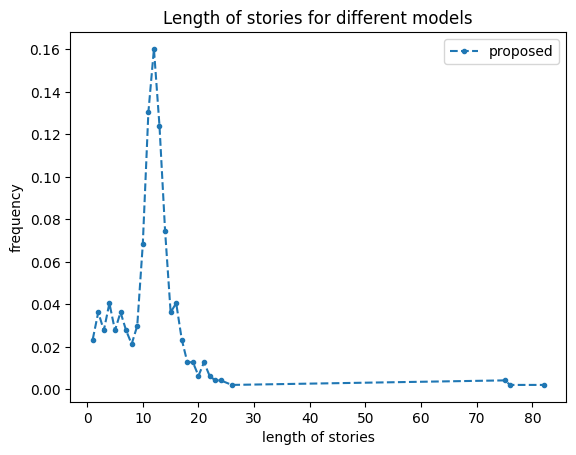

In [413]:
t = length_story_frequency(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128)
total = len(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128)
freq = [w/total for w in list(t.values())]
plt.plot(list(t.keys()), freq, '--.', label='proposed')
plt.xlabel("length of stories")
plt.ylabel("frequency")
plt.title("Length of stories for different models")
plt.legend()
plt.show()

In [388]:
# freq = [w/total for w in list(t.values())]
# new_freq = [(freq[i]+freq[i+1]+freq[i+2])/3 for i in range(len(freq)-2)]
# new_x = [(list(t.keys())[i]+list(t.keys())[i+1]+list(t.keys())[i+2])/3 for i in range(len(list(t.keys()))-2)]
# plt.plot(new_x[:23], new_freq[:23], '--.', label='embedding size = 128')
# plt.xlabel("length of stories")
# plt.ylabel("percentage of frequency")
# plt.title("Length of stories for different embedding size")
# plt.legend()
# plt.show()

In [389]:
# t = length_story_frequency(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128)
# total = len(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128)
# freq = [w/total for w in list(t.values())]
# plt.plot(list(t.keys()), freq, '--.', label='embedding size = 128')
# plt.xlabel("length of stories")
# plt.ylabel("percentage of frequency")
# plt.title("Length of stories for different embedding size")
# plt.legend()
# plt.show()

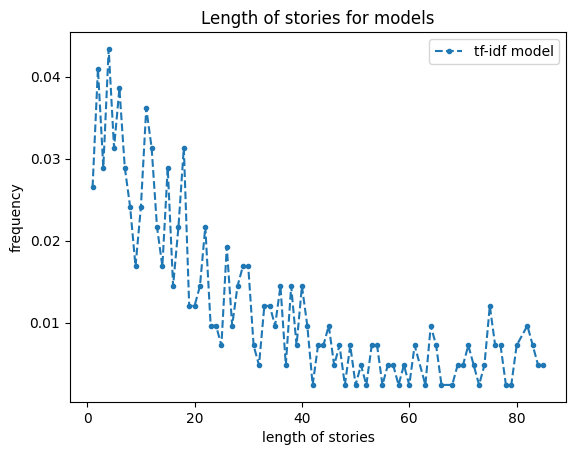

In [391]:
t_keyword = length_story_frequency(result_dict_story_gen_just_tfidf_novel_method_v128)
total_k = len(result_dict_story_gen_just_tfidf_novel_method_v128)
freq_k = [w/total_k for w in list(t_keyword.values())]
plt.plot(list(t_keyword.keys()), freq_k, '--.', label='tf-idf model')
plt.xlabel("length of stories")
plt.ylabel("frequency")
plt.title("Length of stories for models")
plt.legend()
plt.show()

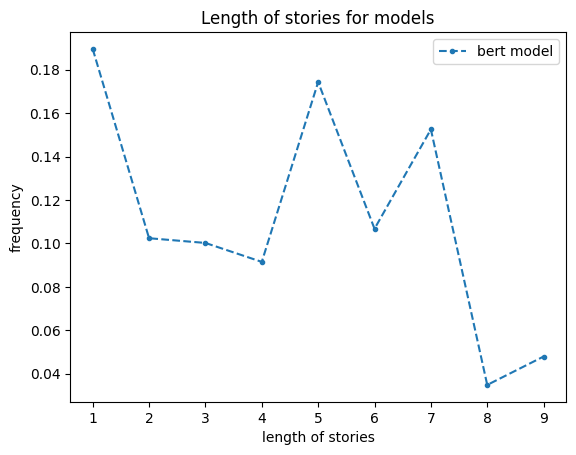

In [392]:
# for just embedding model
t_emb = length_story_frequency(bert)
total_emb= len(bert)
freq_emb = [w/total_emb for w in list(t_emb.values())]
plt.plot(list(t_emb.keys()), freq_emb, '--.', label='bert model')
plt.xlabel("length of stories")
plt.ylabel("frequency")
plt.title("Length of stories for models")
plt.legend()
plt.show()

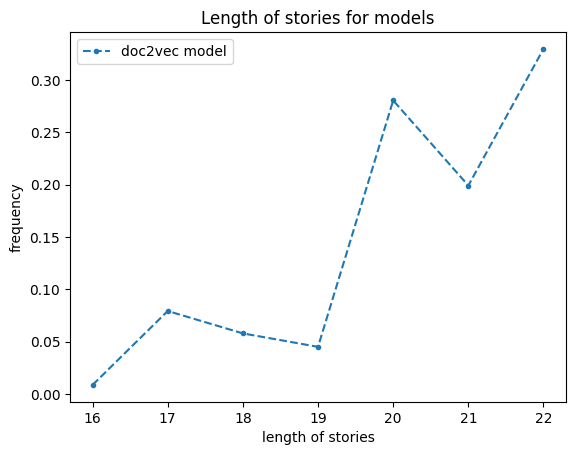

In [462]:
# length for doc2vec
t_doc2vec = length_story_frequency(doc2vec)
total_doc2vec= len(doc2vec)
freq_doc2vec = [w/total_doc2vec for w in list(t_doc2vec.values())]
plt.plot(list(t_doc2vec.keys()), freq_doc2vec, '--.', label='doc2vec model')
plt.xlabel("length of stories")
plt.ylabel("frequency")
plt.title("Length of stories for models")
plt.legend()
plt.show()





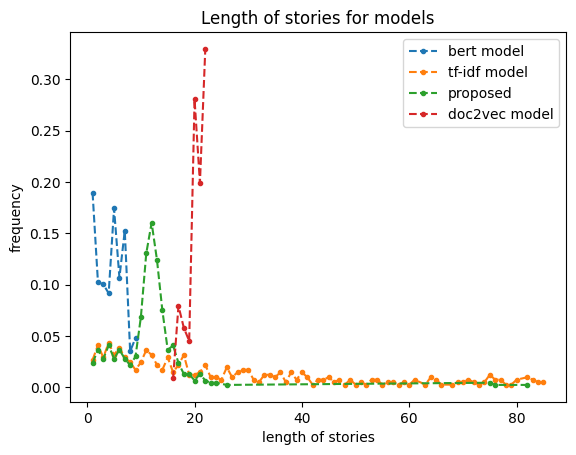

In [463]:
plt.plot(list(t_emb.keys()), freq_emb, '--.', label='bert model')
plt.plot(list(t_keyword.keys()), freq_k, '--.', label='tf-idf model')
plt.plot(list(t.keys()), freq, '--.', label='proposed')
plt.plot(list(t_doc2vec.keys()), freq_doc2vec, '--.', label='doc2vec model')

plt.xlabel("length of stories")
plt.ylabel("frequency")
plt.title("Length of stories for models")
plt.legend()
plt.show()

In [394]:
# model_wo_dif = length_story_frequency(result_dict_story_gen_emb_tfidf_novel_method_without_diffusion)
# total_emb_= len(result_dict_story_gen_emb_tfidf_novel_method_without_diffusion)
# freq_emb_ = [w/total_emb_ for w in list(model_wo_dif.values())]
# plt.plot(list(model_wo_dif.keys()), freq_emb_, '--.', label='just embedding model')
# plt.xlabel("length of stories")
# plt.ylabel("percentage of frequency")
# plt.title("Length of stories for without diffusion model")
# plt.legend()
# plt.show()

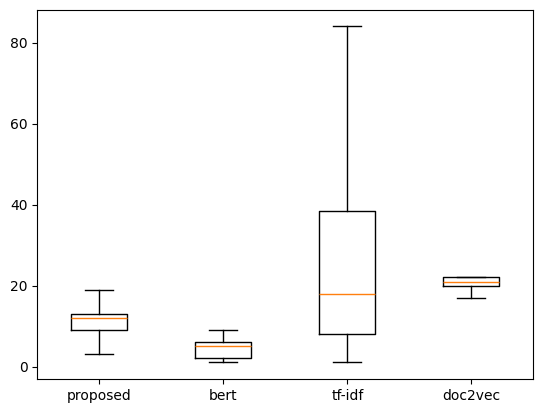

In [464]:

plt.boxplot([[len(proposed[w]) for w in proposed],[len(bert[w]) for w in bert], [len(keyword_based_model[w]) for w in keyword_based_model],  [len(doc2vec[w]) for w in doc2vec]], labels=['proposed', 'bert', 'tf-idf', 'doc2vec'],showfliers=False)
plt.show()

In [420]:
#ABLATION STUDY

t_nodis = length_story_frequency(proposed_without_distribution)
total_t_nodis  = len(proposed_without_distribution)
freq_t_nodis  = [w/total_t_nodis for w in list(t_nodis .values())]

t_nokey = length_story_frequency(proposed_without_keywords)
total_t_nokey  = len(proposed_without_keywords)
freq_t_nokey = [w/total_t_nokey for w in list(t_nokey .values())]

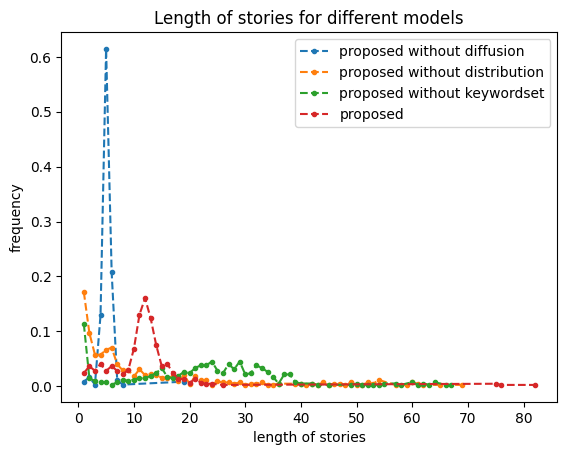

In [421]:
t_nodiff = length_story_frequency(proposed_without_diffusion)
total_nodiff  = len(proposed_without_diffusion)
freq_nodiff  = [w/total_nodiff  for w in list(t_nodiff .values())]
plt.plot(list(t_nodiff .keys()), freq_nodiff , '--.', label='proposed without diffusion')
plt.plot(list(t_nodis.keys()), freq_t_nodis, '--.', label='proposed without distribution')
plt.plot(list(t_nokey.keys()), freq_t_nokey, '--.', label='proposed without keywordset')
plt.plot(list(t.keys()), freq, '--.', label='proposed')

plt.xlabel("length of stories")
plt.ylabel("frequency")
plt.title("Length of stories for different models")
plt.legend()
plt.show()

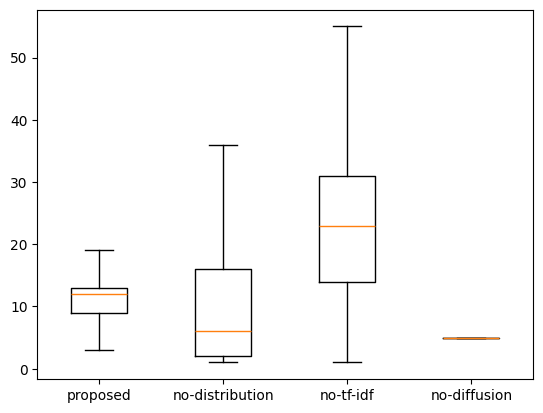

In [423]:
plt.boxplot([[len(proposed[w]) for w in proposed],[len(proposed_without_distribution[w]) for w in proposed_without_distribution], [len(proposed_without_keywords[w]) for w in proposed_without_keywords],  [len(proposed_without_diffusion[w]) for w in proposed_without_diffusion]], labels=['proposed', 'no-distribution', 'no-tf-idf', 'no-diffusion'],showfliers=False)
plt.show()

In [ ]:
# proposed_without_distribution
# proposed_without_diffusion
# bert
# proposed
# keyword_based_model
# proposed_without_keywords


In [349]:
#dispersion metric
teta_list = [w/100 for w in range(65,99,2)]

In [350]:
def disp(d_i, d_j, n, teta, i, j):
  a = contextual_dict[d_i]
  b = contextual_dict[d_j]
  dist = cosine_similarity([a],[b])[0][0]
  if dist < teta:
    return 1/(n+i-j)
  else:
    return 0

In [351]:
def final_disp(story_, teta):
  res = list()
  len_story = len(story_)
  for i in range(len_story-3):
    for j in range(i+2, len_story-1):
      res.append(disp(story_[i], story_[j], len_story, teta, i, j))

  return 1.0 - (sum(res)/(len_story-2 + 0.01))

In [352]:
def dispersion_metric(stories):
    disp_values = list()
    for te_ta in tqdm(teta_list):
      g_value = [final_disp(stories[x], te_ta) for x in stories]
      disp_values.append(sum(g_value)/ len(g_value))
    return disp_values
    

In [395]:
# z is the dispersion value for different thresholds of theta
z = dispersion_metric(proposed)

100%|██████████| 17/17 [02:13<00:00,  7.87s/it]


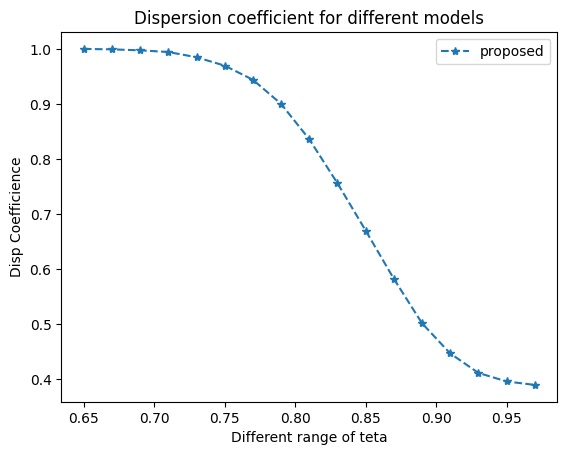

In [396]:
plt.plot(teta_list, z, '--*', label='proposed')
plt.xlabel("Different range of teta")
plt.ylabel("Disp Coefficience")
plt.title("Dispersion coefficient for different models")
plt.legend()
plt.show()

In [397]:
print('dispersion value for vector size 128 is:', z[int(len(teta_list)/2)]) #10 is the median

dispersion value for vector size 128 is: 0.8358111111311433


100%|██████████| 17/17 [14:18<00:00, 50.48s/it]


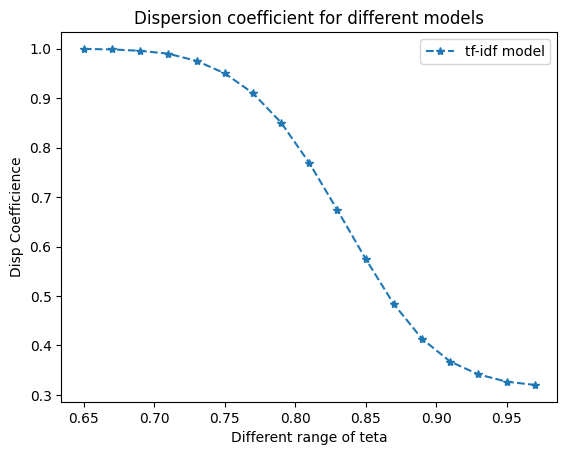

dispersion value for keyword-based is: 0.7690934351074981


In [398]:
#dispersion for keyword based model
# result_dict_story_gen_just_tfidf_novel_method_v128
z_keywords = dispersion_metric(keyword_based_model)
plt.plot(teta_list, z_keywords, '--*', label='tf-idf model')
plt.xlabel("Different range of teta")
plt.ylabel("Disp Coefficience")
plt.title("Dispersion coefficient for different models")
plt.legend()
plt.show()
print('dispersion value for keyword-based is:', z_keywords[int(len(teta_list)/2)]) #10 is the median

100%|██████████| 17/17 [00:07<00:00,  2.28it/s]


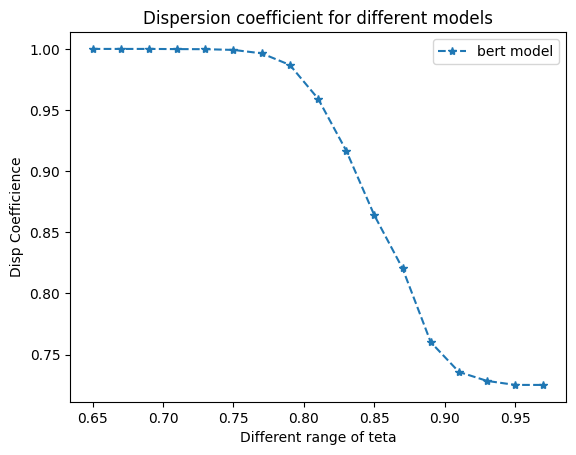

dispersion value for just embedding model is: 0.959372724008084


In [400]:
# just embedding model
# result_dict_story_gen_just_emb_novel_method
z_emb = dispersion_metric(bert)
plt.plot(teta_list, z_emb, '--*', label='bert model')
plt.xlabel("Different range of teta")
plt.ylabel("Disp Coefficience")
plt.title("Dispersion coefficient for different models")
plt.legend()
plt.show()
print('dispersion value for bert model is:', z_emb[int(len(teta_list)/2)]) #10 is the median

100%|██████████| 17/17 [04:39<00:00, 16.44s/it]


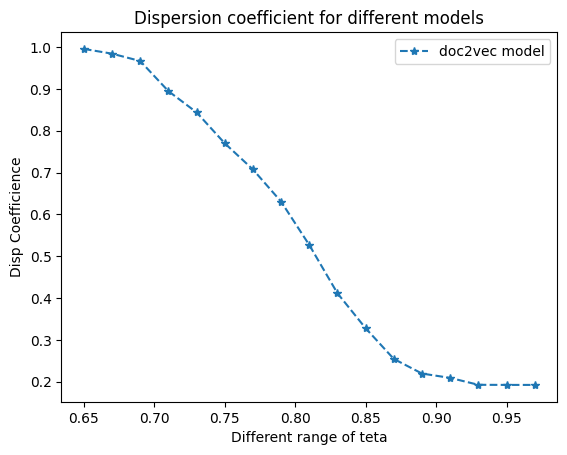

dispersion value for bert model is: 0.5267530493020425


In [461]:
# for dov2vec
z_doc2vec = dispersion_metric(doc2vec)
plt.plot(teta_list, z_doc2vec, '--*', label='doc2vec model')
plt.xlabel("Different range of teta")
plt.ylabel("Disp Coefficience")
plt.title("Dispersion coefficient for different models")
plt.legend()
plt.show()
print('dispersion value for bert model is:', z_doc2vec[int(len(teta_list)/2)]) #10 is the median

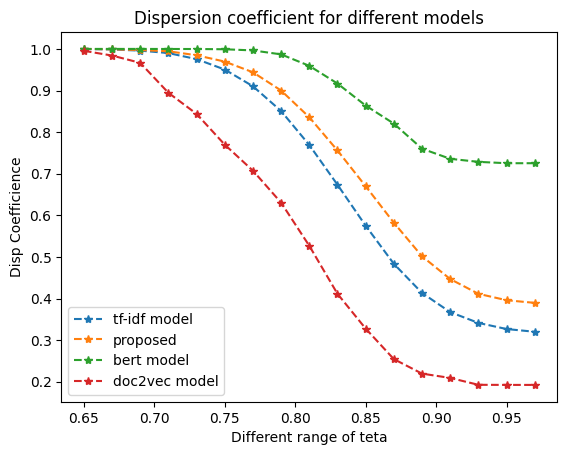

In [465]:
plt.plot(teta_list, z_keywords, '--*', label='tf-idf model')
plt.plot(teta_list, z, '--*', label='proposed')
plt.plot(teta_list, z_emb, '--*', label='bert model')
plt.plot(teta_list, z_doc2vec, '--*', label='doc2vec model')
plt.xlabel("Different range of teta")
plt.ylabel("Disp Coefficience")
plt.title("Dispersion coefficient for different models")
plt.legend()
plt.show()


In [ ]:
#ABLATION STUDY for DISPERSION

100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


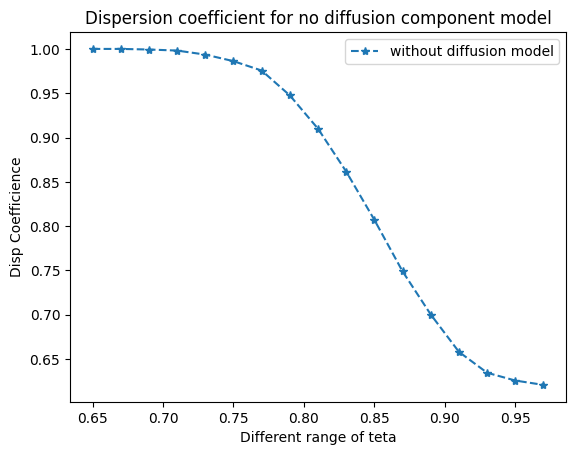

dispersion value for without diffusion model is: 0.9098973492309129


In [427]:
#without diffusion
b_nodiff = dispersion_metric(proposed_without_diffusion)
plt.plot(teta_list, b_nodiff, '--*', label='without diffusion model')
plt.xlabel("Different range of teta")
plt.ylabel("Disp Coefficience")
plt.title("Dispersion coefficient for no diffusion component model")
plt.legend()
plt.show()
print('dispersion value for without diffusion model is:', b_nodiff[int(len(teta_list)/2)]) #10 is the median

100%|██████████| 17/17 [04:47<00:00, 16.93s/it]


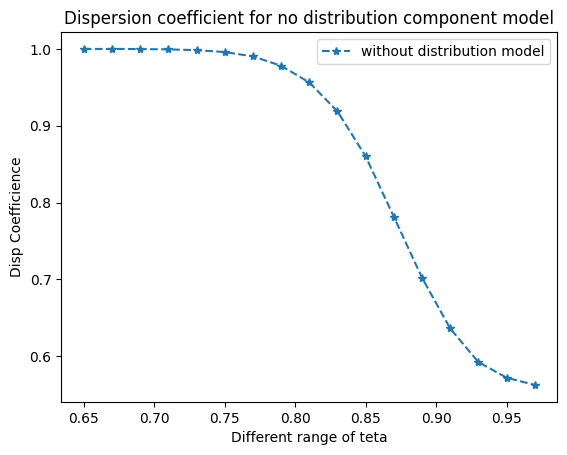

dispersion value for without diffusion model is: 0.9563653976912563


In [428]:
#without distribution
b_nodis = dispersion_metric(proposed_without_distribution)
plt.plot(teta_list, b_nodis, '--*', label='without distribution model')
plt.xlabel("Different range of teta")
plt.ylabel("Disp Coefficience")
plt.title("Dispersion coefficient for no distribution component model")
plt.legend()
plt.show()
print('dispersion value for without diffusion model is:', b_nodis[int(len(teta_list)/2)]) #10 is the median

100%|██████████| 17/17 [08:25<00:00, 29.73s/it]


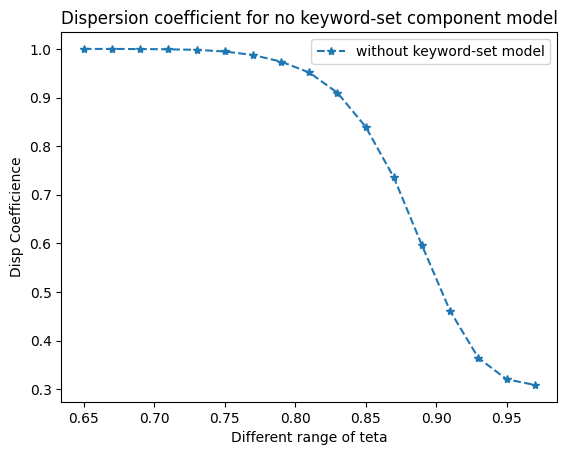

dispersion value for without keyword-set model: 0.9514804842954413


In [433]:
#without keyword-set
b_nokey = dispersion_metric(proposed_without_keywords)
plt.plot(teta_list, b_nokey, '--*', label='without keyword-set model')
plt.xlabel("Different range of teta")
plt.ylabel("Disp Coefficience")
plt.title("Dispersion coefficient for no keyword-set component model")
plt.legend()
plt.show()
print('dispersion value for without keyword-set model:', b_nokey[int(len(teta_list)/2)]) #10 is the median

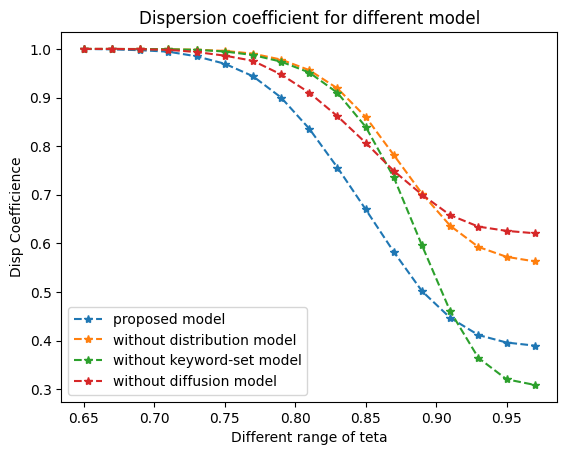

In [434]:
plt.plot(teta_list, z, '--*', label='proposed model')
plt.plot(teta_list, b_nodis, '--*', label='without distribution model')
plt.plot(teta_list, b_nokey, '--*', label='without keyword-set model')
plt.plot(teta_list, b_nodiff, '--*', label='without diffusion model')
plt.xlabel("Different range of teta")
plt.ylabel("Disp Coefficience")
plt.title("Dispersion coefficient for different model")
plt.legend()
plt.show()

In [106]:
#SEC metric, story evaluation coefficient
# def story_evaluation_vec (stories_embedding, t_max):
#   n_stories = len(stories_embedding)
#   res = list()
#   for story in stories_embedding:
#     temp_res = list()
#     for i in range(len(story)-1):
#       temp = cosine_similarity([story[i]], [story[i+1]])[0][0]
#       temp_res.append(  (10*t_max - 10*temp + 1)* np.exp( -10*(t_max - temp))   )
#     res.append(np.average(temp_res))
#   return res

In [425]:
def story_evaluation_avg (stories, t_max):
    n_stories = len(stories)
    res = list()
    for story_id in stories:
        if len(stories[story_id])<2:
            continue
        temp_res = list()
        for i in range(len(stories[story_id])-1):
          temp = cosine_similarity([contextual_dict[stories[story_id][i]]], [contextual_dict[stories[story_id][i+1]]])[0][0]
          temp_res.append((10*t_max - 10*temp + 1)* np.exp( -10*(t_max - temp)))
        res.append(np.average(temp_res))
    return np.average(res)

In [426]:
thre = [w/100 for w in range(80,99,1)]
sec_res = []
for t_max in tqdm(thre):
    sec_res.append(story_evaluation_avg(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128, t_max))

100%|██████████| 19/19 [00:22<00:00,  1.17s/it]


In [275]:
max(sec_res)

0.8718642096079855

In [276]:
print('Story Evaluation Coefficient for proposed model', max(sec_res))

Story Evaluation Coefficient for proposed model 0.8718642096079855


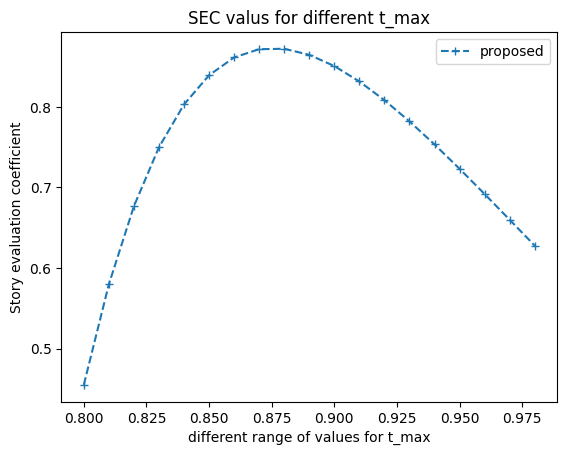

In [424]:
plt.plot(thre, sec_res, '--+', label='proposed')
plt.xlabel("different range of values for t_max")
plt.ylabel("Story evaluation coefficient")
plt.title("SEC valus for different t_max")
plt.legend()
plt.show()

In [435]:
# sec for keyword based model
thre = [w/100 for w in range(80,99,1)]
sec_res_keyword = []
for t_max in tqdm(thre):
    sec_res_keyword.append(story_evaluation_avg(keyword_based_model, t_max))

100%|██████████| 19/19 [00:48<00:00,  2.57s/it]


In [436]:
print('Story Evaluation Coefficient for keyword-based model model', max(sec_res_keyword))

Story Evaluation Coefficient for keyword-based model model 0.8573631513734922


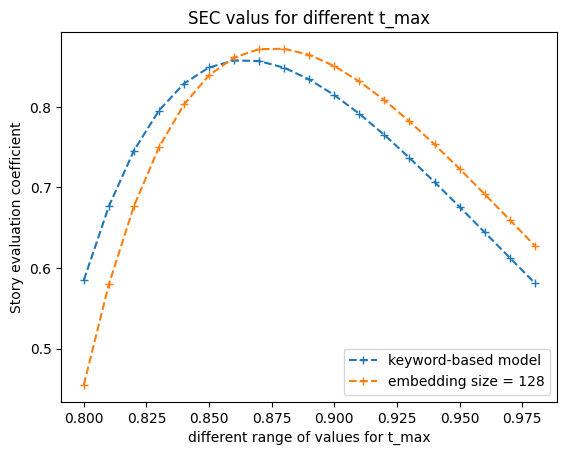

In [281]:
# plt.plot(thre, sec_res_keyword, '--+', label='keyword-based model')
# plt.plot(thre, sec_res, '--+', label='embedding size = 128')
# plt.xlabel("different range of values for t_max")
# plt.ylabel("Story evaluation coefficient")
# plt.title("SEC valus for different t_max")
# plt.legend()
# plt.show()

In [440]:
# for just embedding model
# result_dict_story_gen_just_emb_novel_method

thre = [w/100 for w in range(80,99,1)]
sec_res_bert = []
for t_max in tqdm(thre):
    sec_res_bert.append(story_evaluation_avg(bert, t_max))
print('Story Evaluation Coefficient for bert model', max(sec_res_bert))

100%|██████████| 19/19 [00:07<00:00,  2.71it/s]

Story Evaluation Coefficient for bert model 0.9754935357597271


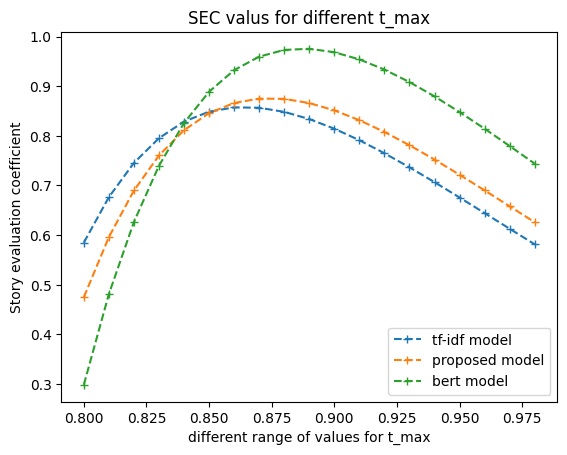

In [459]:
# doc2vec model

thre = [w/100 for w in range(80,99,1)]
sec_res_doc2vec = []
for t_max in tqdm(thre):
    sec_res_doc2vec.append(story_evaluation_avg(doc2vec, t_max))
print('Story Evaluation Coefficient for doc2vec model', max(sec_res_doc2vec))

100%|██████████| 19/19 [00:39<00:00,  2.06s/it]

Story Evaluation Coefficient for doc2vec model 0.8745446977345586


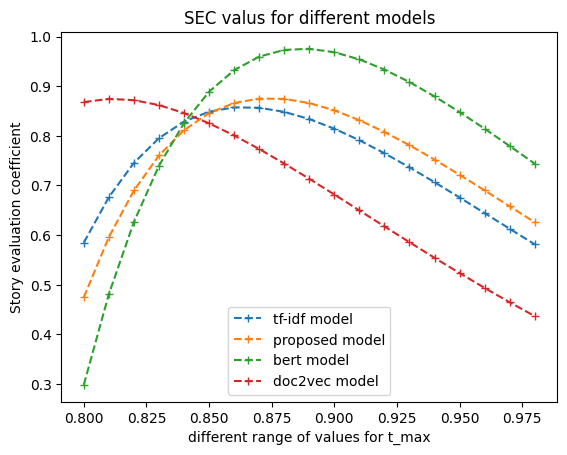

In [460]:
plt.plot(thre, sec_res_keyword, '--+', label='tf-idf model')
plt.plot(thre, sec_res, '--+', label='proposed model')
plt.plot(thre, sec_res_bert, '--+', label='bert model')
plt.plot(thre, sec_res_doc2vec, '--+', label='doc2vec model')

plt.xlabel("different range of values for t_max")
plt.ylabel("Story evaluation coefficient")
plt.title("SEC valus for different models")
plt.legend()
plt.show()

In [ ]:
# ABLATION STUDY

In [442]:
thre = [w/100 for w in range(80,99,1)]
sec_res_nodiff = []
for t_max in tqdm(thre):
    sec_res_nodiff.append(story_evaluation_avg(proposed_without_diffusion, t_max))
print('Story Evaluation Coefficient for no diffusion component', max(sec_res_nodiff))

100%|██████████| 19/19 [00:07<00:00,  2.60it/s]

Story Evaluation Coefficient for no diffusion component 0.8694985086821204


In [444]:
thre = [w/100 for w in range(80,99,1)]
sec_res_nokey = []
for t_max in tqdm(thre):
    sec_res_nokey.append(story_evaluation_avg(proposed_without_keywords, t_max))
print('Story Evaluation Coefficient for no keyword-set component', max(sec_res_nokey))

100%|██████████| 19/19 [00:41<00:00,  2.19s/it]

Story Evaluation Coefficient for no keyword-set 0.9698322116196343


In [445]:
thre = [w/100 for w in range(80,99,1)]
sec_res_nodis = []
for t_max in tqdm(thre):
    sec_res_nodis.append(story_evaluation_avg(proposed_without_distribution, t_max))
print('Story Evaluation Coefficient for no distribution ', max(sec_res_nodis))

100%|██████████| 19/19 [00:23<00:00,  1.23s/it]

Story Evaluation Coefficient for no distribution  0.9466305809095233


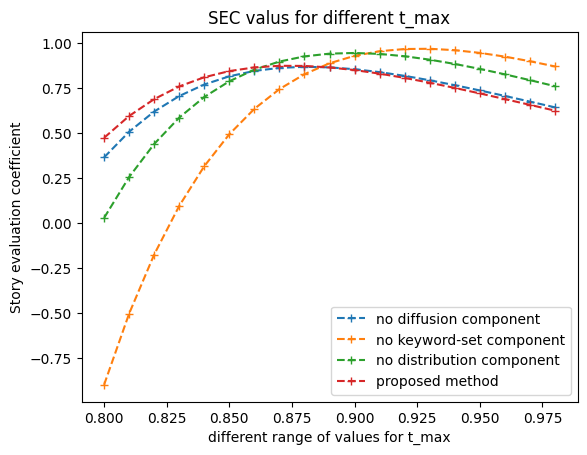

In [446]:
plt.plot(thre, sec_res_nodiff, '--+', label='no diffusion component')
plt.plot(thre, sec_res_nokey, '--+', label='no keyword-set component')
plt.plot(thre, sec_res_nodis, '--+', label='no distribution component')
plt.plot(thre, sec_res, '--+', label='proposed method')
plt.xlabel("different range of values for t_max")
plt.ylabel("Story evaluation coefficient")
plt.title("SEC valus for different t_max")
plt.legend()
plt.show()

In [ ]:
# Hit@K metric

In [133]:
def keyword_extractor(x_tf_idf_, list_of_words_in_tfidf_, top_keywords_):
    temp_dict = dict()
    for i,j in zip(x_tf_idf_, list_of_words_in_tfidf_):
        temp_dict[j] = i
    return sorted(temp_dict.items(), key=lambda x:x[1], reverse=True)[:top_keywords_]

In [ ]:
# keyword_extractor(tf_idf_dict[seed_doc], list_of_words_in_tfidf, 100)

In [218]:
# in generates a hit@k for each story in stories. to get the final value, the outcome must be get averaged
def hit(stories, k):
    res = []
    for story_id in stories:
        if len(stories[story_id])<2:
            continue
        res_per_story = 0
        for i in range(len(stories[story_id])-1):
            key_1 = set([w[0] for w in keyword_extractor(tf_idf_dict[stories[story_id][i]], list_of_words_in_tfidf, 10*k)])
            key_2 = set([w[0] for w in keyword_extractor(tf_idf_dict[stories[story_id][i+1]], list_of_words_in_tfidf, 10*k)])
            if len(key_1.intersection(key_2))>0:
                res_per_story += 1
        res_per_story = res_per_story/(len(stories[story_id])-1)
        res.append(res_per_story)
    return res 

In [451]:
l_1 = hit(proposed,1)
l_3 = hit(proposed,3)
l_5 = hit(proposed,5)
print('for porposed model')
print(np.average(l_1))
print(np.average(l_3))
print(np.average(l_5))

for porposed model
0.39473439263150084
0.6378966226309462
0.8056920862694699


In [452]:
# for keyword based model
l_1_keyword = hit(keyword_based_model,1)
l_3_keyword = hit(keyword_based_model,3)
l_5_keyword = hit(keyword_based_model,5)
print('for keyword-based model')
print(np.average(l_1_keyword))
print(np.average(l_3_keyword))
print(np.average(l_5_keyword))

for keyword-based model
0.3688378066004517
0.6186160275445148
0.7949220426290892


In [453]:
# for bert model

l_1_bert = hit(bert,1)
l_3_bert = hit(bert,3)
l_5_bert = hit(bert,5)
print('for just bert model')
print(np.average(l_1_bert))
print(np.average(l_3_bert))
print(np.average(l_5_bert))

for just bert model
0.09085701484895034
0.1883768561187916
0.4601126472094214


In [458]:
#doc2vec

result_dict_story_gen_emb_tfidf_novel_method_without_diffusion
# for no diffusion component model
l_1_doc2vec = hit( doc2vec,1)
l_3_doc2vec = hit(doc2vec ,3)
l_5_doc2vec = hit( doc2vec,5)
print('for doc2vec model')
print(np.average(l_1_doc2vec))
print(np.average(l_3_doc2vec))
print(np.average(l_5_doc2vec))


for doc2vec model
0.043778790301950456
0.04765678840002134
0.22721404426378536


In [ ]:
# ABLATION STUDY

In [454]:
l_1_nodif = hit(proposed_without_diffusion,1)
l_3_nodif = hit(keyword_based_model,3)
l_5_nodif = hit(keyword_based_model,5)
print('for no diffusion model')
print(np.average(l_1_nodif))
print(np.average(l_3_nodif))
print(np.average(l_5_nodif))

for no diffusion model
0.3335597826086957
0.6186160275445148
0.7949220426290892


In [455]:
l_1_nodis = hit(proposed_without_distribution,1)
l_3_nodis = hit(proposed_without_distribution,3)
l_5_nodis = hit(proposed_without_distribution,5)
print('for no distribution model')
print(np.average(l_1_nodis))
print(np.average(l_3_nodis))
print(np.average(l_5_nodis))

for no distribution model
0.42870357069959647
0.6938412625324455
0.8653993031071541


In [456]:
l_1_nokey = hit(proposed_without_keywords,1)
l_3_nokey = hit(proposed_without_keywords,3)
l_5_nokey = hit(proposed_without_keywords,5)
print('for no keyword-set model')
print(np.average(l_1_nokey))
print(np.average(l_3_nokey))
print(np.average(l_5_nokey))

for no keyword-set model
0.16110868411090004
0.347237189284662
0.553287218973561


In [ ]:
length_rank_dict_proposed_30 = dict()
for i in range(200):
    length_rank_dict_proposed_30[i] = []
for i in proposed:
    length_rank_dict_proposed_30[len(proposed[i])].append(hit_per_story(proposed[i], 3))
    
for i in range(200):
    length_rank_dict_proposed_30[i] = np.average(length_rank_dict_proposed_30[i]) 

length_rank_dict_bert_30 = dict()
for i in range(200):
    length_rank_dict_bert_30[i] = []
for i in bert:
    length_rank_dict_bert_30[len(bert[i])].append(hit_per_story(bert[i], 3))
    
for i in range(200):
    length_rank_dict_bert_30[i] = np.average(length_rank_dict_bert_30[i]) 

length_rank_dict_doc2vec_30 = dict()
for i in range(200):
    length_rank_dict_doc2vec_30[i] = []
for i in doc2vec:
    length_rank_dict_doc2vec_30[len(doc2vec[i])].append(hit_per_story(doc2vec[i], 3))
    
for i in length_rank_dict_doc2vec_30:
    length_rank_dict_doc2vec_30[i] = np.average(length_rank_dict_doc2vec_30[i])


length_rank_dict_keyword_30 = dict()
for i in range(300):
    length_rank_dict_keyword_30[i] = []
for i in keyword_based_model:
    length_rank_dict_keyword_30[len(keyword_based_model[i])].append(hit_per_story(keyword_based_model[i], 3))
    
for i in length_rank_dict_keyword_30:
    length_rank_dict_keyword_30[i] = np.average(length_rank_dict_keyword_30[i]) 



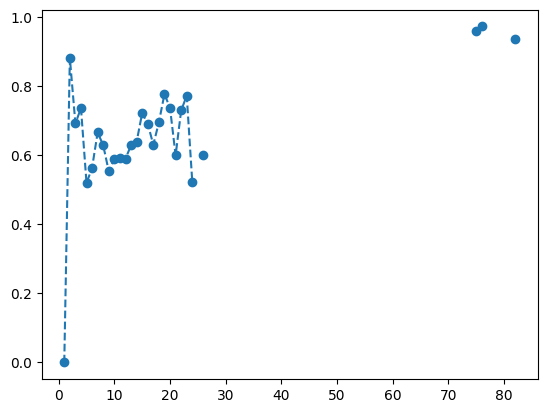

In [525]:
x_array_p_3 = list(length_rank_dict_proposed_30.keys())
y_array_p_3 = [length_rank_dict_proposed_30[w] for w in x_array_p_3]
plt.plot(x_array_p_3, y_array_p_3, '--o', label='proposed')
plt.show()

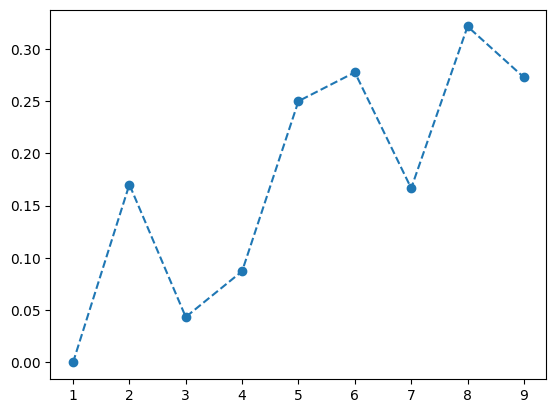

In [526]:
x_array_b_3 = list(length_rank_dict_bert_30.keys())
y_array_b_3 = [length_rank_dict_bert_30[w] for w in x_array_b_3]
plt.plot(x_array_b_3, y_array_b_3, '--o', label='bert')
plt.show()

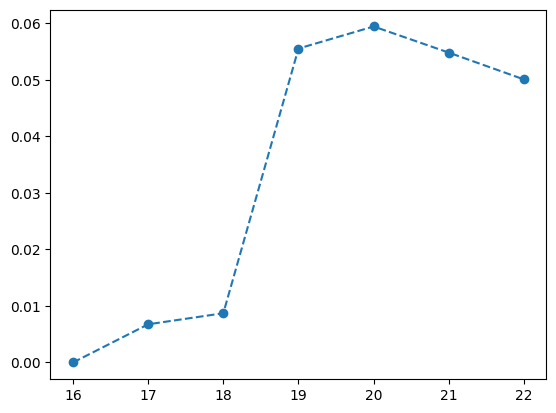

In [531]:
x_array_d_3 = list(length_rank_dict_doc2vec_30.keys())
y_array_d_3 = [length_rank_dict_doc2vec_30[w] for w in x_array_d_3]
plt.plot(x_array_d_3, y_array_d_3, '--o', label='doc2vec')
plt.show()

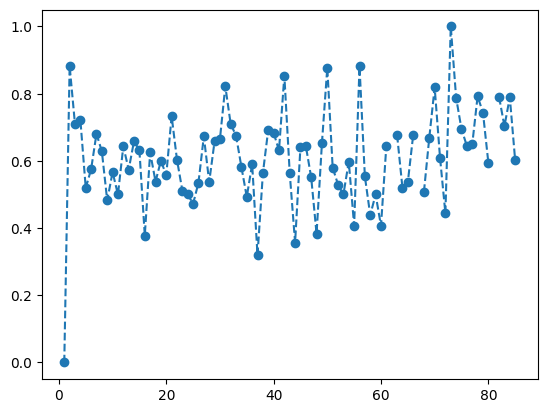

In [532]:
x_array_3 = list(length_rank_dict_keyword_30.keys())
y_array_3 = [length_rank_dict_keyword_30[w] for w in x_array_3]
plt.plot(x_array_3, y_array_3, '--o', label='keyword-entity')
plt.show()

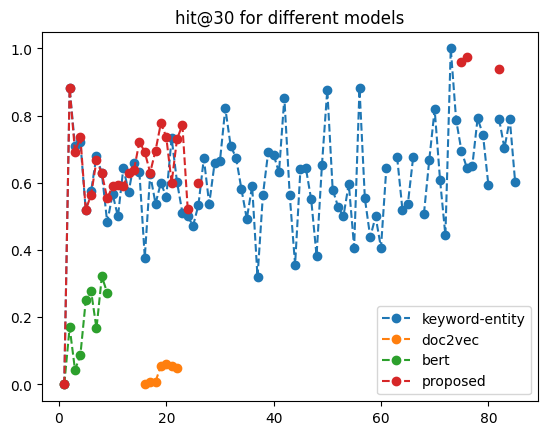

In [533]:

plt.plot(x_array_3, y_array_3, '--o', label='keyword-entity')
plt.plot(x_array_d_3, y_array_d_3, '--o', label='doc2vec')
plt.plot(x_array_b_3, y_array_b_3, '--o', label='bert')
plt.plot(x_array_p_3, y_array_p_3, '--o', label='proposed')
plt.title('hit@30 for different models')
plt.legend()
plt.show()

In [534]:
length_rank_dict_proposed_50 = dict()
for i in range(200):
    length_rank_dict_proposed_50[i] = []
for i in proposed:
    length_rank_dict_proposed_50[len(proposed[i])].append(hit_per_story(proposed[i], 5))
    
for i in range(200):
    length_rank_dict_proposed_50[i] = np.average(length_rank_dict_proposed_50[i]) 

length_rank_dict_bert_50 = dict()
for i in range(200):
    length_rank_dict_bert_50[i] = []
for i in bert:
    length_rank_dict_bert_50[len(bert[i])].append(hit_per_story(bert[i], 5))
    
for i in range(200):
    length_rank_dict_bert_50[i] = np.average(length_rank_dict_bert_50[i]) 

length_rank_dict_doc2vec_50 = dict()
for i in range(200):
    length_rank_dict_doc2vec_50[i] = []
for i in doc2vec:
    length_rank_dict_doc2vec_50[len(doc2vec[i])].append(hit_per_story(doc2vec[i], 5))
    
for i in length_rank_dict_doc2vec_50:
    length_rank_dict_doc2vec_50[i] = np.average(length_rank_dict_doc2vec_50[i])


length_rank_dict_keyword_50 = dict()
for i in range(300):
    length_rank_dict_keyword_50[i] = []
for i in keyword_based_model:
    length_rank_dict_keyword_50[len(keyword_based_model[i])].append(hit_per_story(keyword_based_model[i], 5))
    
for i in length_rank_dict_keyword_50:
    length_rank_dict_keyword_50[i] = np.average(length_rank_dict_keyword_50[i]) 



/home/ali/Virtual_python/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/ali/Virtual_python/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


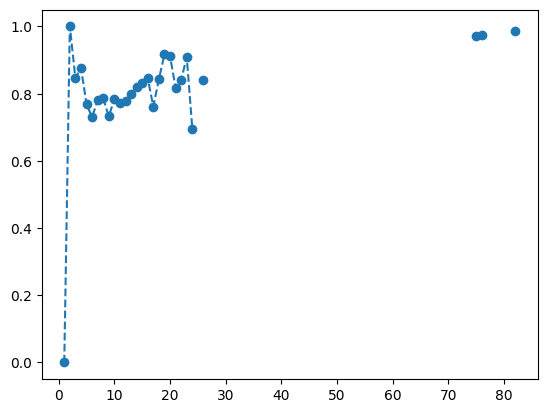

In [535]:
x_array_p_5 = list(length_rank_dict_proposed_50.keys())
y_array_p_5 = [length_rank_dict_proposed_50[w] for w in x_array_p_5]
plt.plot(x_array_p_5, y_array_p_5, '--o', label='proposed')
plt.show()

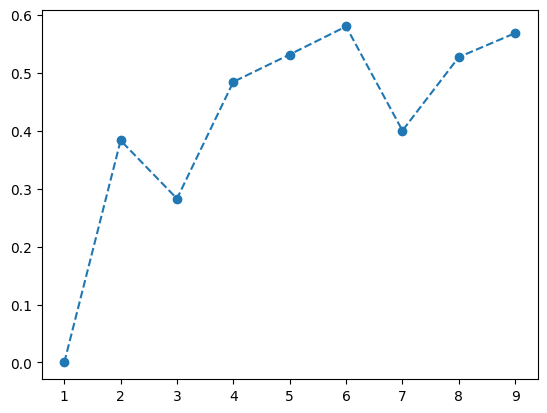

In [536]:
x_array_b_5 = list(length_rank_dict_bert_50.keys())
y_array_b_5 = [length_rank_dict_bert_50[w] for w in x_array_b_5]
plt.plot(x_array_b_5, y_array_b_5, '--o', label='bert')
plt.show()

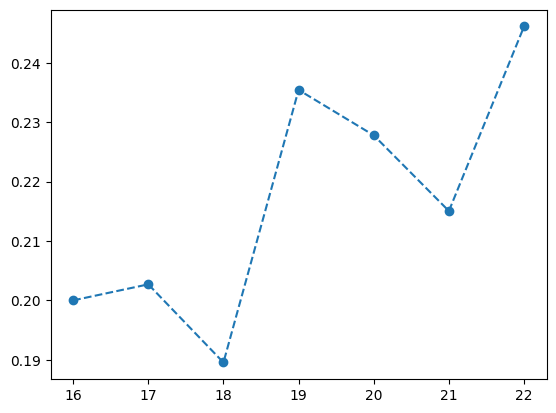

In [537]:
x_array_d_5 = list(length_rank_dict_doc2vec_50.keys())
y_array_d_5 = [length_rank_dict_doc2vec_50[w] for w in x_array_d_5]
plt.plot(x_array_d_5, y_array_d_5, '--o', label='doc2vec')
plt.show()

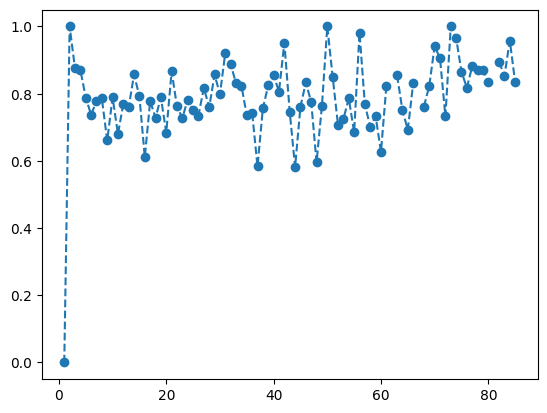

In [538]:
x_array_5 = list(length_rank_dict_keyword_50.keys())
y_array_5 = [length_rank_dict_keyword_50[w] for w in x_array_5]
plt.plot(x_array_5, y_array_5, '--o', label='keyword-entity')
plt.show()

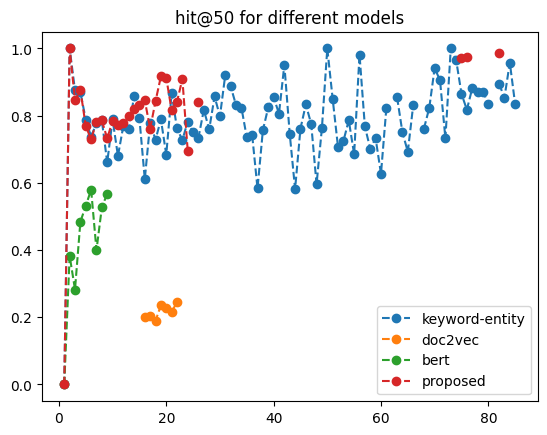

In [539]:

plt.plot(x_array_5, y_array_5, '--o', label='keyword-entity')
plt.plot(x_array_d_5, y_array_d_5, '--o', label='doc2vec')
plt.plot(x_array_b_5, y_array_b_5, '--o', label='bert')
plt.plot(x_array_p_5, y_array_p_5, '--o', label='proposed')
plt.title('hit@50 for different models')
plt.legend()
plt.show()

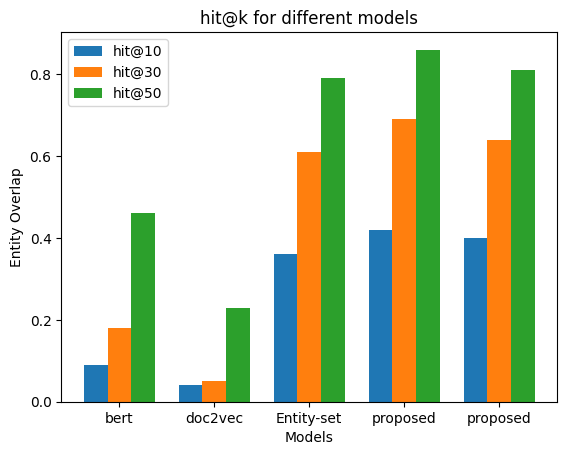

In [565]:
N = 5
ind = np.arange(N)  
width = 0.25

h_1 = [0.09, 0.04, 0.36, 0.42, 0.40] 
bar1 = plt.bar(ind, h_1, width) 
  
h_3 = [0.18, 0.05, 0.61, 0.69, 0.64] 
bar2 = plt.bar(ind+width, h_3, width) 
  
h_4 = [0.46, 0.23, 0.79, 0.86, 0.81] 
bar3 = plt.bar(ind+width*2, h_4, width) 


plt.xlabel("Models") 
plt.ylabel('Entity Overlap') 
plt.title("hit@k for different models") 
  
plt.xticks(ind+width,['bert', 'doc2vec', 'Entity-set', 'proposed', 'proposed']) 
plt.legend( (bar1, bar2, bar3), ('hit@10', 'hit@30', 'hit@50') ) 
plt.show() 

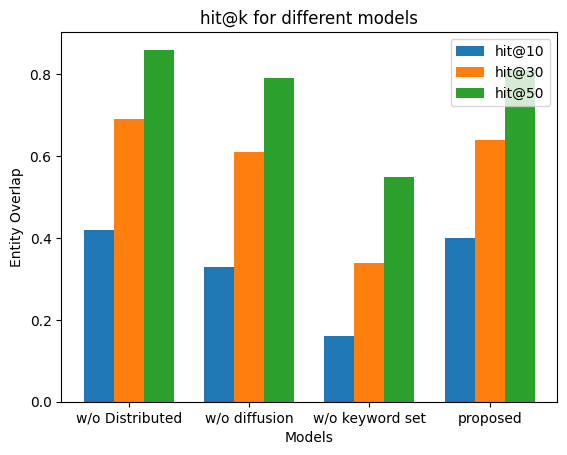

In [566]:
#ablation Study
N = 4
ind = np.arange(N)  
width = 0.25

h_1 = [0.42, 0.33, 0.16, 0.40] 
bar1 = plt.bar(ind, h_1, width) 
  
h_3 = [0.69, 0.61, 0.34, 0.64] 
bar2 = plt.bar(ind+width, h_3, width) 
  
h_4 = [0.86, 0.79, 0.55, 0.81] 
bar3 = plt.bar(ind+width*2, h_4, width) 


plt.xlabel("Models") 
plt.ylabel('Entity Overlap') 
plt.title("hit@k for different models") 
  
plt.xticks(ind+width,['w/o Distributed', 'w/o diffusion', 'w/o keyword set', 'proposed']) 
plt.legend( (bar1, bar2, bar3), ('hit@10', 'hit@30', 'hit@50') ) 
plt.show() 

In [229]:
def hit_per_story(story, k):
    if len(story)<2:
        return 0
    res_per_story = 0
    for i in range(len(story)-1):
        key_1 = set([w[0] for w in keyword_extractor(tf_idf_dict[story[i]], list_of_words_in_tfidf, 10*k)])
        key_2 = set([w[0] for w in keyword_extractor(tf_idf_dict[story[i+1]], list_of_words_in_tfidf, 10*k)])
        if len(key_1.intersection(key_2))>0:
            res_per_story += 1
    return res_per_story/(len(story)-1)

In [512]:
length_rank_dict_proposed = dict()
for i in range(200):
    length_rank_dict_proposed[i] = []
for i in proposed:
    length_rank_dict_proposed[len(proposed[i])].append(hit_per_story(proposed[i], 1))
    
for i in range(200):
    length_rank_dict_proposed[i] = np.average(length_rank_dict_proposed[i]) 

In [511]:
length_rank_dict_bert = dict()
for i in range(200):
    length_rank_dict_bert[i] = []
for i in bert:
    length_rank_dict_bert[len(bert[i])].append(hit_per_story(bert[i], 1))
    
for i in range(200):
    length_rank_dict_bert[i] = np.average(length_rank_dict_bert[i]) 

In [493]:
length_rank_dict_doc2vec = dict()
for i in range(200):
    length_rank_dict_doc2vec[i] = []
for i in doc2vec:
    length_rank_dict_doc2vec[len(doc2vec[i])].append(hit_per_story(doc2vec[i], 1))
    
for i in length_rank_dict_doc2vec:
    length_rank_dict_doc2vec[i] = np.average(length_rank_dict_doc2vec[i])

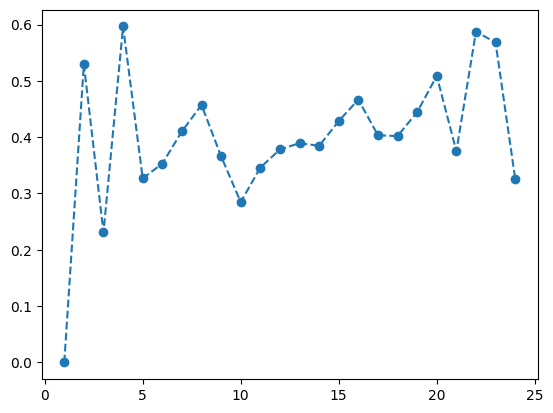

In [519]:
x_array_p = list(length_rank_dict_proposed.keys())[:26]
y_array_p = [length_rank_dict_proposed[w] for w in x_array_p]
plt.plot(x_array_p, y_array_p, '--o', label='proposed')
plt.show()

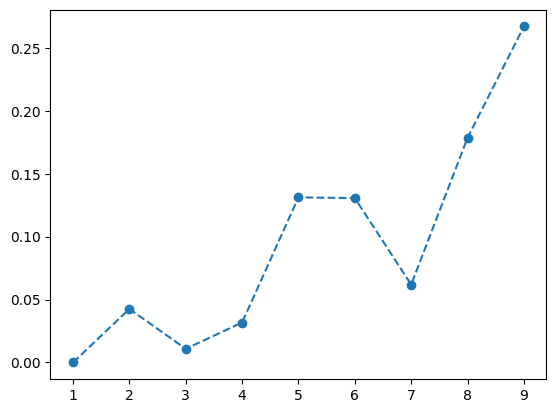

In [514]:
x_array_b = list(length_rank_dict_bert.keys())
y_array_b = [length_rank_dict_bert[w] for w in x_array_b]
plt.plot(x_array_b, y_array_b, '--o', label='bert')
plt.show()

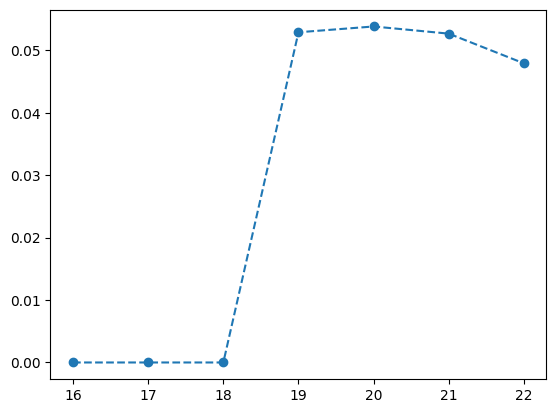

In [510]:
x_array_d = list(length_rank_dict_doc2vec.keys())
y_array_d = [length_rank_dict_doc2vec[w] for w in x_array_d]
plt.plot(x_array_d, y_array_d, '--o', label='doc2vec')
plt.show()

In [481]:
length_rank_dict_keyword = dict()
for i in range(300):
    length_rank_dict_keyword[i] = []
for i in keyword_based_model:
    length_rank_dict_keyword[len(keyword_based_model[i])].append(hit_per_story(keyword_based_model[i], 1))
    
for i in range(300):
    length_rank_dict_keyword[i] = np.average(length_rank_dict_keyword[i]) 

for i in length_rank_dict_keyword:
    length_rank_dict_keyword[i] = np.average(length_rank_dict_keyword[i])

        

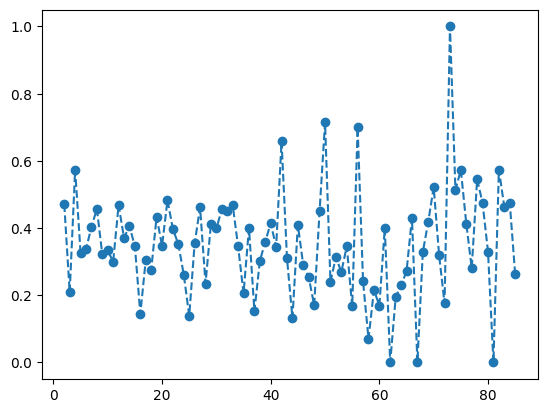

In [494]:
x_array = list(length_rank_dict_keyword.keys())[2:86]
y_array = [length_rank_dict_keyword[w] for w in x_array]
plt.plot(x_array, y_array, '--o', label='keyword-entity')
plt.show()

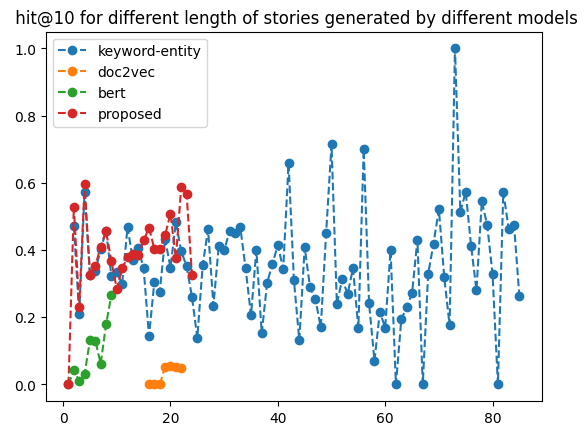

In [521]:
plt.plot(x_array, y_array, '--o', label='keyword-entity')
plt.plot(x_array_d, y_array_d, '--o', label='doc2vec')
plt.plot(x_array_b, y_array_b, '--o', label='bert')
plt.plot(x_array_p, y_array_p, '--o', label='proposed')
plt.title(" hit@10 for different length of stories generated by different models")
plt.legend()
plt.show()

100%|██████████| 3/3 [03:18<00:00, 66.12s/it]


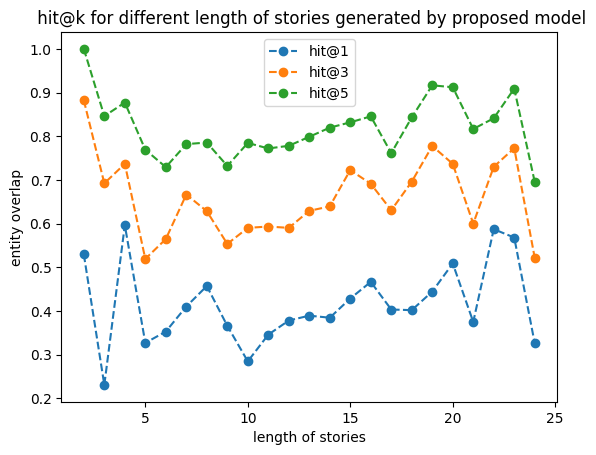

In [239]:
for k in tqdm([1,3,5]):
    length_rank_dict = dict()
    for i in range(100):
        length_rank_dict[i] = []
    for i in result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128:
        length_rank_dict[len(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128[i])].append(hit_per_story(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128[i], k))
        
    for i in range(100):
        length_rank_dict[i] = np.average(length_rank_dict[i]) 
    x_array = list(length_rank_dict.keys())[2:25]
    y_array = [length_rank_dict[w] for w in x_array]
    plt.plot(x_array, y_array, '--o', label='hit@{}'.format(k))
plt.xlabel("length of stories")
plt.ylabel("entity overlap")
plt.title(" hit@k for different length of stories generated by proposed model")
plt.legend()
plt.show()

1